# DeepDigitor

DeepDigitor is a neural network project designed to classify handwritten digits using the MNIST dataset. This project implements a fully manual Multilayer Perceptron (MLP) without using any pre-built deep learning frameworks like TensorFlow, Keras, PyTorch, or Scikit-learn. Instead, the MLP architecture is constructed from scratch using basic Python libraries such as CuPy to perform operations like matrix multiplication, activation functions, and backpropagation. The goal is to understand and demonstrate the inner workings of neural networks in a transparent and educational manner.

In [46]:
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt

# Table of Contents
1. [Building the model from scratch](#Building-the-model-from-scratch)
2. [MNIST dataset](#MNIST-dataset)
3. [Training the model](#Training-the-model)
4. [Conclusion](#Conclusion)

# Building the model from scratch

## Perceptron

A **Perceptron** is a fundamental unit of a neural network that mimics the behavior of a biological neuron. It takes multiple inputs, applies corresponding weights, sums them up, and produces an output.

### Structure of a Perceptron
A perceptron consists of the following components:

1. **Inputs $ (x_1, x_2, ..., x_n) $**  
   - Numerical features that the model processes.

2. **Weights $( w_1, w_2, ..., w_n) $**  
   - Learnable parameters that determine the importance of each input.

3. **Bias $ b $**  
   - A constant value that helps adjust the output.

4. **Summation $ z $**  
   - The perceptron computes the weighted sum of inputs plus bias:

   $$ z = \sum_{i=1}^{n} w_i x_i + b $$

### Perceptron in a Multi-Layer Perceptron (MLP)
In a **Multi-Layer Perceptron (MLP)**, perceptrons are stacked in multiple layers to build a deep network capable of solving complex tasks. The main components of an MLP are:

- **Input Layer**: Receives raw data.  
- **Hidden Layers**: Process the data through multiple perceptrons.  
- **Output Layer**: Produces the final prediction.  

By combining multiple perceptrons, MLPs can learn patterns and relationships in data, making them suitable for tasks like image recognition and natural language processing.


### Perceptron Weight and Bias Initialization

#### Weight Initialization: He Initialization
The weights are initialized using **He initialization**, which is defined as:

$$
W \sim \mathcal{N}(0, \frac{2}{n_{\text{input}}})
$$

##### Why He Initialization?
- Designed for **ReLU-based networks**.
- Prevents **vanishing and exploding gradients**.
- Keeps the variance of activations stable across layers.

#### Bias Initialization: Zero
The bias is initialized to **zero**:

- Bias does not suffer from the same issues as weights (such as symmetry problems).
- Zero initialization is a standard choice in neural network design.

## Activation Functions

Activation functions are applied to the output of a single perceptron to introduce non-linearity, allowing the neural network to model complex relationships in data. Without activation functions, the network would simply behave as a linear model, unable to learn intricate patterns.

### Why Are Activation Functions Important?
- **Non-linearity**: Helps model complex relationships in data.  
- **Gradient-based optimization**: Enables efficient training using backpropagation.  
- **Output control**: Prevents extreme values that could destabilize learning.  

### Common Activation Functions

#### 1. Sigmoid Function
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$
- **Range**: \( (0,1) \)  
- **Use Case**: Binary classification.  
- **Limitation**: Vanishing gradients slow down learning.  

#### 2. ReLU (Rectified Linear Unit)
$$
\text{ReLU}(z) = \max(0, z)
$$
- **Range**: \( [0, \infty) \)  
- **Use Case**: Deep learning models.  
- **Limitation**: Some neurons may become inactive (Dying ReLU).  

#### 3. Softmax Function
$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$
- **Range**: \( (0,1) \), values sum to 1.  
- **Use Case**: Multi-class classification.  

#### 4. Tanh Function
$$
\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$
- **Range**: \( (-1,1) \)  
- **Use Case**: Zero-centered transformations.  
- **Limitation**: Still suffers from vanishing gradients.  

### Summary Table

| Activation Function | Best For | Potential Issues |  
|---------------------|----------|------------------|  
| **Sigmoid** | Binary classification | Vanishing gradients |  
| **ReLU** | Deep networks | Dying ReLU problem |  
| **Softmax** | Multi-class classification | Computational cost |  
| **Tanh** | Zero-centered data | Vanishing gradients |  



In [47]:
class ActivationFunction:
    @staticmethod
    def activate(z):
        raise NotImplementedError(
            "activate method should be implemented by subclasses.")

    @staticmethod
    def derivative(z):
        raise NotImplementedError(
            "derivative method should be implemented by subclasses.")


class Sigmoid(ActivationFunction):
    @staticmethod
    def activate(z):
        return 1 / (1 + cp.exp(-z))

    @staticmethod
    def derivative(z):
        sigmoid = Sigmoid.activate(z)
        return sigmoid * (1 - sigmoid)


class ReLU(ActivationFunction):
    @staticmethod
    def activate(z):
        return cp.maximum(0, z)

    @staticmethod
    def derivative(z):
        return (z > 0).astype(float)


class Softmax(ActivationFunction):
    @staticmethod
    def activate(z):
        exp_z = cp.exp(z - cp.max(z, axis=-1, keepdims=True))
        return exp_z / cp.sum(exp_z, axis=-1, keepdims=True)

    @staticmethod
    def derivative(z):
        softmax = Softmax.activate(z)
        return softmax * (1 - softmax)


class Tanh(ActivationFunction):
    @staticmethod
    def activate(z):
        return cp.tanh(z)

    @staticmethod
    def derivative(z):
        tanh_z = cp.tanh(z)
        return 1 - tanh_z ** 2

## Loss Functions in Neural Networks

A **Loss Function** (also called a **Cost Function**) is a mathematical function used to quantify how well or poorly the model’s predictions match the actual target values (ground truth). The goal of training a neural network is to minimize this loss, which means adjusting the model's parameters (weights and biases) to make predictions as accurate as possible.

Loss functions are critical because they provide the feedback needed for the optimization process, such as **Gradient Descent**, to update the weights and biases during training.

### Types of Loss Functions
There are various types of loss functions, each suited to specific types of problems, such as regression or classification.

---

### Common Loss Functions

#### **Mean Squared Error (MSE) Loss**
- **Use Case**: Primarily used in **regression** tasks.
- **Formula**:  
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{\text{true}}^{(i)} - y_{\text{pred}}^{(i)})^2
  $$
  Where:
  - $y_{\text{true}}^{(i)}$ is the actual value for the \(i\)-th data point.
  - $y_{\text{pred}}^{(i)}$ is the predicted value for the \(i\)-th data point.

- **Characteristics**:
  - Measures the average squared difference between the actual and predicted values.
  - Sensitive to **outliers**, as large errors are squared, amplifying their effect.

- **Derivative**:
  $$
  \frac{\partial}{\partial y_{\text{pred}}} \text{MSE} = \frac{-2(y_{\text{true}} - y_{\text{pred}})}{n}
  $$
  The gradient of the MSE is used to update the weights during backpropagation.

---

#### **Cross-Entropy Loss**
- **Use Case**: Typically used in **classification** problems, both binary and multi-class classification.
- **Formula (Binary Classification)**:  
  $$
  \text{Cross-Entropy} = -\frac{1}{n} \sum_{i=1}^{n} \left(y_{\text{true}}^{(i)} \log(y_{\text{pred}}^{(i)}) + (1 - y_{\text{true}}^{(i)}) \log(1 - y_{\text{pred}}^{(i)})\right)
  $$
  Where:
  - $y_{\text{true}}^{(i)}$ is the true class label (0 or 1) for the \(i\)-th data point.
  - $y_{\text{pred}}^{(i)}$ is the predicted probability for the \(i\)-th data point.

- **Characteristics**:
  - Cross-entropy is often used when the model outputs probabilities (e.g., with the **Sigmoid** or **Softmax** activation functions).
  - It works well for **binary classification** and **multi-class classification** tasks.

- **Derivative**:
  $$
  \frac{\partial}{\partial y_{\text{pred}}} \text{Cross-Entropy} = \frac{-y_{\text{true}}}{y_{\text{pred}}}
  $$
  The derivative is used to calculate gradients during backpropagation for model weight updates.

---

#### **Hinge Loss**
- **Use Case**: Often used in **Support Vector Machines (SVMs)** for **binary classification** tasks.
- **Formula**:  
  $$
  \text{Hinge Loss} = \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - y_{\text{true}}^{(i)} \cdot y_{\text{pred}}^{(i)})
  $$
  Where:
  - $y_{\text{true}}^{(i)}$ is the true class label (\(+1\) or \(-1\)) for the \(i\)-th data point.
  - $y_{\text{pred}}^{(i)}$ is the predicted value for the \(i\)-th data point.

- **Characteristics**:
  - Hinge loss is commonly used with SVMs to encourage a margin between the decision boundary and the data points.
  - It penalizes predictions that are on the wrong side of the margin.

- **Derivative**:
  $$
  \frac{\partial}{\partial y_{\text{pred}}} \text{Hinge Loss} =
  \begin{cases}
  -y_{\text{true}} & \text{if } y_{\text{true}} \cdot y_{\text{pred}} < 1 \\
  0 & \text{otherwise}
  \end{cases}
  $$
  The derivative helps compute gradients used to optimize the model.

---

#### **Huber Loss**
- **Use Case**: Primarily used in **regression** tasks, especially when there are **outliers** in the data.
- **Formula**:
  $$
  \text{Huber Loss} =
  \begin{cases}
  0.5 \cdot (y_{\text{true}} - y_{\text{pred}})^2 & \text{for } |y_{\text{true}} - y_{\text{pred}}| \leq \delta \\
  \delta \cdot (|y_{\text{true}} - y_{\text{pred}}| - 0.5 \cdot \delta) & \text{otherwise}
  \end{cases}
  $$
  Where $\delta$ is a threshold that determines the boundary between the squared error and absolute error.

- **Characteristics**:
  - Combines **MSE** (mean squared error) and **MAE** (mean absolute error), making it less sensitive to outliers than MSE.
  - Often used when the data contains **large errors** (outliers) that might skew the model.

- **Derivative**:
  $$
  \frac{\partial}{\partial y_{\text{pred}}} \text{Huber Loss} =
  \begin{cases}
  -(y_{\text{true}} - y_{\text{pred}}) & \text{if } |y_{\text{true}} - y_{\text{pred}}| \leq \delta \\
  -\delta \cdot \text{sign}(y_{\text{true}} - y_{\text{pred}}) & \text{otherwise}
  \end{cases}
  $$
  The derivative is used for gradient-based optimization in backpropagation.

In [48]:
class LossFunction:
    @staticmethod
    def compute(y_true, y_pred):
        raise NotImplementedError("compute method should be implemented by subclasses.")

    @staticmethod
    def derivative(y_true, y_pred):
        raise NotImplementedError("derivative method should be implemented by subclasses.")


class MeanSquaredError(LossFunction):
    @staticmethod
    def compute(y_true, y_pred):
        return cp.mean((y_true - y_pred) ** 2)

    @staticmethod
    def derivative(y_true, y_pred):
        return -2 * (y_true - y_pred) / y_true.size


class CrossEntropyLoss(LossFunction):
    @staticmethod
    def compute(y_true, y_pred):
        epsilon = 1e-8  # To prevent log(0)
        return -cp.sum(y_true * cp.log(y_pred + epsilon)) / y_true.shape[0]

    @staticmethod
    def derivative(y_true, y_pred):
        epsilon = 1e-12
        y_pred = cp.clip(y_pred, epsilon, 1. - epsilon)
        return (y_pred - y_true)


class HingeLoss(LossFunction):
    @staticmethod
    def compute(y_true, y_pred):
        return cp.mean(cp.maximum(0, 1 - y_true * y_pred))

    @staticmethod
    def derivative(y_true, y_pred):
        return cp.where(y_true * y_pred < 1, -y_true, 0)



class HuberLoss(LossFunction):
    @staticmethod
    def compute(y_true, y_pred, delta=1.0):
        error = y_true - y_pred
        is_small_error = cp.abs(error) <= delta
        squared_loss = 0.5 * error ** 2
        linear_loss = delta * (cp.abs(error) - 0.5 * delta)
        return cp.mean(cp.where(is_small_error, squared_loss, linear_loss))

    @staticmethod
    def derivative(y_true, y_pred, delta=1.0):
        error = y_true - y_pred
        is_small_error = cp.abs(error) <= delta
        return cp.where(is_small_error, -error, -delta * cp.sign(error))

## Optimizers

Optimizers are algorithms used to adjust a neural network's weights and biases during training to minimize the loss function. They play a key role in updating the model parameters based on gradients computed during backpropagation.

### Stochastic Gradient Descent (SGD)

**SGD** is one of the simplest optimization algorithms. It updates weights using the gradient of the loss function:
$$
w = w - \eta \cdot \frac{\partial L}{\partial w}
$$
Where $ \eta $ is the learning rate.

**Characteristics**:
- Simple and widely used.
- Can be noisy due to updates based on individual data points or small batches.
- Often slower to converge.

---

### Adam Optimizer

**Adam (Adaptive Moment Estimation)** combines the benefits of **momentum** and **RMSprop**. It adapts the learning rate for each parameter and uses exponentially decaying averages of past gradients and squared gradients.

**Formula**:
$$
m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot \frac{\partial L}{\partial w}
$$
$$
v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot \left(\frac{\partial L}{\partial w}\right)^2
$$
The final weight update rule is:
$$
w_{\text{new}} = w - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

**Characteristics**:
- **Adaptive learning rates** for each parameter.
- **Momentum and bias correction** help in faster and smoother convergence.
- Works well for noisy or sparse gradients.

---

### Comparison

| Optimizer        | Learning Rate Adaptation | Momentum     | Suitable For                            |
|------------------|--------------------------|--------------|-----------------------------------------|
| **SGD**          | No                       | No           | Large datasets, simple problems        |
| **Adam**         | Yes                      | Yes          | Noisy, sparse gradients; large datasets |


In [49]:
class Optimizer:
    def update(self, weights, biases, dW, dB):
        raise NotImplementedError("This method should be implemented by subclasses.")


class SGD(Optimizer):
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, weights, biases, dW, dB):
        new_weights = weights - self.learning_rate * dW
        new_biases = biases - self.learning_rate * dB
        return new_weights, new_biases

class Adam(Optimizer):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate  # Step size
        self.beta1 = beta1                  # Exponential decay rate for first moment
        self.beta2 = beta2                  # Exponential decay rate for second moment
        self.epsilon = epsilon              # Small constant to prevent division by zero
        self.m_w = 0                        # Initialize first moment for weights
        self.v_w = 0                        # Initialize second moment for weights
        self.m_b = 0                        # Initialize first moment for biases
        self.v_b = 0                        # Initialize second moment for biases
        self.t = 0                          # Initialize timestep

    def update(self, weights, biases, dW, dB):
        self.t += 1  # Increment timestep

        # Update biased first moment estimates
        self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * dW
        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * dB

        # Update biased second moment estimates
        self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (dW ** 2)
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (dB ** 2)

        # Compute bias-corrected first moment estimates
        m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
        m_b_hat = self.m_b / (1 - self.beta1 ** self.t)

        # Compute bias-corrected second moment estimates
        v_w_hat = self.v_w / (1 - self.beta2 ** self.t)
        v_b_hat = self.v_b / (1 - self.beta2 ** self.t)

        # Update weights and biases
        new_weights = weights - self.learning_rate * m_w_hat / ((v_w_hat ** 0.5) + self.epsilon)
        new_biases = biases - self.learning_rate * m_b_hat / ((v_b_hat ** 0.5) + self.epsilon)

        return new_weights, new_biases

## Layer in a Neural Network

A **Layer** in a neural network is a collection of **neurons** that perform certain transformations on the input data. Each layer has **weights**, **biases**, and an **activation function**. The main task of a layer is to take input data, perform a linear transformation, and apply an activation function to produce output data. Layers are the building blocks of a neural network and are responsible for learning the representations of data at different levels.

In this implementation, a **Layer** is designed to:
1. Perform a **forward pass**.
2. Compute the **backward pass** for gradient updates.


### **Forward Propagation** (`forward`)

In **forward propagation**, data flows from the input through the layer, and the output is calculated:
- The **linear transformation** $ z = X \cdot W + b $ is computed, where:
  - $ X $ is the input matrix.
  - $ W $ is the weight matrix.
  - $ b $ is the bias vector.
- The **activation function** is then applied to the result of the linear transformation $ z $, producing the output $ a $. This output is passed to the next layer or used as the final output of the model.

The forward method can be described as:
$$
a = \text{activation}(X \cdot W + b)
$$
Where $ a $ is the output of the layer.

### **Backward Propagation** (`backward`)

**Backward propagation** is used to calculate the gradients (i.e., derivatives) with respect to the weights and biases, which are then used to update them in order to minimize the loss function. This is done using the chain rule of calculus:

- **Step 1: Compute the Gradient of the Loss**:
  The derivative of the loss function with respect to the activation \( a \) is propagated backward, resulting in \( dA \).

- **Step 2: Compute the Gradient of the Weights and Biases**:
  - The gradient of the activation function with respect to \( z \) is calculated.
  - The gradient of the weights and biases is computed:
    $$
    dZ = dA \times \text{activation\_derivative}(z)
    $$
    $$
    dW = \frac{1}{m} \cdot X^T \cdot dZ
    $$
    $$
    dB = \frac{1}{m} \cdot \sum(dZ)
    $$
  Where \( m \) is the number of samples in the batch.

- **Step 3: Update Weights and Biases**:
  The **optimizer** (e.g., SGD) is then used to update the weights and biases using the gradients:
  $$
    W_{\text{new}} = W - \eta \cdot dW
  $$
  $$
    b_{\text{new}} = b - \eta \cdot dB
  $$

The updated weights and biases are returned, and the gradient is passed to the previous layer (in the case of multi-layer networks).

---

In a neural network, each **layer** performs two main operations:
1. **Forward propagation**, where the input is transformed and passed through the activation function.
2. **Backward propagation**, where gradients are computed, and the optimizer updates the model parameters to minimize the loss.

This cycle repeats during the training process, allowing the network to gradually learn to make accurate predictions.


In [50]:
class Layer:
    def __init__(self, input_size, num_neurons, activation_function, optimizer, dropout_rate=0.0):
        self.input_size = input_size
        self.num_neurons = num_neurons
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.dropout_rate = dropout_rate

        self.weights = cp.random.randn(
            input_size, num_neurons) * cp.sqrt(2.0 / input_size)
        self.biases = cp.zeros((1, num_neurons))
        self.dropout_mask = None

    def forward(self, inputs, training=True):
        self.inputs = cp.asarray(inputs)
        self.z = cp.dot(self.inputs, self.weights) + self.biases
        self.a = self.activation_function.activate(self.z)

        if training and self.dropout_rate > 0.0 and self.a.shape[1] != 10:  # Skip dropout on output layer
            self.dropout_mask = cp.random.binomial(1, 1 - self.dropout_rate, size=self.a.shape) / (1 - self.dropout_rate)
            self.a *= self.dropout_mask
        else:
            self.dropout_mask = None

        return self.a

    def backward(self, dA, l1_lambda=0.0, l2_lambda=0.0):
        if self.dropout_mask is not None:
            dA *= self.dropout_mask

        dZ = dA * self.activation_function.derivative(self.z)
        dW = cp.dot(self.inputs.T, dZ) / self.inputs.shape[0]
        dB = cp.sum(dZ, axis=0, keepdims=True) / self.inputs.shape[0]

        self.weights, self.biases = self.optimizer.update(self.weights, self.biases, dW, dB)
        return cp.dot(dZ, self.weights.T)

## Multi-Layer Perceptron (MLP)

A **Multi-Layer Perceptron (MLP)** is a type of **neural network** consisting of multiple layers of neurons. Each neuron in the MLP is connected to every neuron in the previous and next layers (fully connected), making it a **feedforward neural network**. The layers consist of:

1. **Input Layer**: Takes the input features.
2. **Hidden Layers**: Perform transformations on the input data using activation functions, with optional **dropout** for regularization.
3. **Output Layer**: Provides the final predictions.

The MLP is capable of learning complex mappings from input to output through training, enhanced by techniques like **dropout** and **L1/L2 regularization** to prevent overfitting.

---

## How Does the MLP Work?

The MLP consists of **layers**, and each **layer** performs two main functions:

1. **Forward Propagation**:
   - The input is passed through each layer sequentially.
   - Each layer computes a **linear transformation** $ z = X \cdot W + b $ followed by an **activation function** to produce the output.
   - During training, **dropout** may be applied to randomly deactivate a fraction of neurons (controlled by a **dropout rate**) to improve generalization.
   - The final output of the last layer is the prediction $ y_{\text{pred}} $.

2. **Backward Propagation**:
   - After computing the prediction, the **loss** (error) between the predicted values and true labels is calculated.
   - The **backpropagation algorithm** computes gradients of the weights and biases with respect to the loss using the chain rule.
   - **L1 and L2 regularization** terms may be added to the gradients to penalize large weights, encouraging sparsity (L1) or smaller weights (L2).
   - These gradients are then used to **update the weights** and **biases** via an optimizer (like **SGD** or **Adam**).

---

### Training the MLP

The MLP is trained using the **gradient descent** method, adjusting its parameters (weights and biases) to minimize the loss function, which may include **L1/L2 regularization** terms. Techniques like **dropout** are applied during training to prevent overfitting.

### Epochs and Batch Size

- **Epoch**: One complete pass through the entire training dataset. During each epoch, the model processes all training examples, performs forward and backward passes, and updates the weights and biases.
- **Batch**: The data is divided into smaller **mini-batches** for efficiency. The **batch size** determines how many samples are used per gradient update.

In each epoch, the MLP processes the data in **mini-batches**:
1. Data is shuffled to improve training and prevent undesirable patterns.
2. Each mini-batch is processed through forward propagation (with **dropout** if enabled) and gradients are computed in backward propagation (including **L1/L2 regularization** if specified).
3. The **weights and biases** are updated after each mini-batch.

---

### MLP Architecture

An MLP model is composed of multiple **layers**, where each layer consists of neurons that perform linear transformations and apply activation functions. The number of layers, neurons per layer, and regularization techniques are determined during model design.

### **Model Flow:**
1. **Layer Initialization**: Each layer is initialized with weights (using **He initialization**) and biases (initialized to 0). The weights are adjusted during training based on gradients, influenced by **L1/L2 regularization** if applied.
2. **Forward Pass**: The model computes activations using the input data and weights. **Dropout** may randomly set neuron outputs to zero during training (skipped in the output layer). Activations flow to the final output layer.
3. **Loss Calculation**: The **loss function** computes the error between predicted and actual values, optionally augmented with **L1 regularization** ($ \lambda_1 \sum |W| $) and **L2 regularization** ($ \lambda_2 \sum W^2 $) terms.
4. **Backward Pass**: Backpropagation computes gradients of the loss with respect to each weight and bias. **L1 regularization** adds a penalty proportional to the absolute weights, while **L2 regularization** adds a penalty proportional to the squared weights.
5. **Weight Updates**: The optimizer (e.g., **SGD** or **Adam**) adjusts weights and biases using the computed gradients, incorporating regularization effects.

---

### The MLP Training Process

1. **Data Preparation**: Training data $ X $ and true labels $ y $ are provided. Optionally, **validation data** $ X_{\text{val}} $ and $ y_{\text{val}} $ evaluate performance on unseen data.
2. **Model Training**:
   - Training runs for a specified number of **epochs**. In each epoch, the model processes data in **mini-batches**, applying **dropout** during forward passes and **L1/L2 regularization** during updates.
   - The **loss function**, including regularization terms, is computed at the end of each epoch to track performance.
   - If **validation data** is provided, the **validation loss** (also including regularization) is computed after each epoch, with **dropout** disabled.
3. **Termination**: Training ends after the specified epochs or when the loss converges.

---

### How Does MLP Learn?

#### **Forward Propagation**:
Each layer computes a weighted sum of inputs, adds a bias, and applies an activation function. During training, **dropout** randomly deactivates neurons (controlled by a **dropout rate**) to reduce overfitting. The final output is compared to the true label using a **loss function**, which may include **L1/L2 regularization** terms.

#### **Backward Propagation**:
- The **loss** measures the difference between predicted and true labels, augmented by **L1 regularization** (sum of absolute weights) and **L2 regularization** (sum of squared weights) if enabled.
- **Gradients** of the loss with respect to weights and biases are computed using the chain rule, incorporating regularization penalties.
- These gradients update the weights and biases via an optimizer, minimizing the combined loss and improving predictions.

The model's **weights and biases** are iteratively updated to minimize the loss, with **dropout** enhancing generalization and **L1/L2 regularization** controlling weight magnitude. Optimization continues until convergence.

---

The **MLP** model consists of multiple connected layers, each performing linear transformations followed by activation functions. During training:
- The model learns by adjusting weights and biases through **forward and backward propagation**.
- **Dropout** prevents overfitting by randomly dropping neurons during training.
- **L1 and L2 regularization** penalize large weights, improving model robustness.
- Data is processed in **mini-batches** across multiple **epochs**, gradually refining performance.

With this process, the MLP learns complex data relationships and delivers accurate predictions.

In [51]:
class MLP:
    def __init__(self, loss_function=CrossEntropyLoss, l1_lambda=0.0, l2_lambda=0.0, dropout_rate=0.0):
        self.layers = []
        self.loss_function = loss_function
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.dropout_rate = dropout_rate

    def add_layer(self, input_size, num_neurons, activation_function, optimizer):
        self.layers.append(Layer(input_size, num_neurons, activation_function, optimizer, self.dropout_rate))

    def forward(self, X, training=True):
        output = cp.asarray(X)
        for layer in self.layers:
            output = layer.forward(output, training=training)
        return output

    def backward(self, X, y_true, loss_function):
        y_pred = self.forward(X, training=True)
        dA = loss_function.derivative(y_true, y_pred)
        for layer in reversed(self.layers):
            dA = layer.backward(dA, self.l1_lambda, self.l2_lambda)
        return dA

    def train(self, X, y, epochs=10, batch_size=32, verbose=True, X_val=None, y_val=None):
        n_samples = X.shape[0]
        X = cp.asarray(X)
        y = cp.asarray(y)

        if X_val is not None and y_val is not None:
            X_val = cp.asarray(X_val)
            y_val = cp.asarray(y_val)

        for epoch in range(1, epochs + 1):
            indices = cp.arange(n_samples)
            cp.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, n_samples, batch_size):
                end_idx = min(start_idx + batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                self.backward(X_batch, y_batch, self.loss_function)

            if verbose:
                y_pred = self.forward(X, training=False)  # No dropout for loss computation
                loss = self.loss_function.compute(y, y_pred)

                l1_loss = 0.0
                l2_loss = 0.0
                for layer in self.layers:
                    l1_loss += cp.sum(cp.abs(layer.weights)) * self.l1_lambda
                    l2_loss += cp.sum(cp.square(layer.weights)) * self.l2_lambda
                total_loss = loss + l1_loss + l2_loss

                if X_val is not None and y_val is not None:
                    y_val_pred = self.forward(X_val, training=False)
                    val_loss = self.loss_function.compute(y_val, y_val_pred)
                    # Add regularization to validation loss too
                    val_total_loss = val_loss + l1_loss + l2_loss
                    print(
                        f"Epoch {epoch}/{epochs} - Train Loss: {total_loss:.4f} | Val Loss: {val_total_loss:.4f}")
                else:
                    print(f"Epoch {epoch}/{epochs} - Loss: {total_loss:.4f}")

    def summary(self):
        print("MLP Structure:")
        for idx, layer in enumerate(self.layers, start=1):
            print(f"Layer {idx}: {layer.num_neurons} neurons, Input Size: {layer.input_size}, Activation: {layer.activation_function.__class__.__name__}")

The Metric class provides evaluation metrics for multi-class classification models. It includes accuracy, precision, recall, and F1-score calculations.

In [52]:
class Metric:
    @staticmethod
    def accuracy(y_true, y_pred):
        """Computes multi-class accuracy."""
        y_true_labels = cp.argmax(y_true, axis=1)  # Convert one-hot to class labels
        y_pred_labels = cp.argmax(y_pred, axis=1)
        return cp.mean(y_true_labels == y_pred_labels)

    @staticmethod
    def precision(y_true, y_pred, average='macro'):
        """Computes precision for multi-class classification."""
        y_true_labels = cp.argmax(y_true, axis=1)
        y_pred_labels = cp.argmax(y_pred, axis=1)
        num_classes = y_true.shape[1]

        precisions = []
        for c in range(num_classes):
            tp = cp.sum((y_pred_labels == c) & (y_true_labels == c))
            fp = cp.sum((y_pred_labels == c) & (y_true_labels != c))
            precision = tp / (tp + fp + 1e-12)  # Avoid division by zero
            precisions.append(precision)

        if average == 'macro':
            return cp.mean(cp.array(precisions))
        return precisions  # Return per-class precision

    @staticmethod
    def recall(y_true, y_pred, average='macro'):
        """Computes recall for multi-class classification."""
        y_true_labels = cp.argmax(y_true, axis=1)
        y_pred_labels = cp.argmax(y_pred, axis=1)
        num_classes = y_true.shape[1]

        recalls = []
        for c in range(num_classes):
            tp = cp.sum((y_pred_labels == c) & (y_true_labels == c))
            fn = cp.sum((y_pred_labels != c) & (y_true_labels == c))
            recall = tp / (tp + fn + 1e-12)  # Avoid division by zero
            recalls.append(recall)

        if average == 'macro':
            return cp.mean(cp.array(recalls))
        return recalls  # Return per-class recall

    @staticmethod
    def f1_score(y_true, y_pred, average='macro'):
        """Computes F1-score for multi-class classification."""
        precision = Metric.precision(y_true, y_pred, average=None)
        recall = Metric.recall(y_true, y_pred, average=None)

        f1_scores = []
        for p, r in zip(precision, recall):
            f1 = 2 * (p * r) / (p + r + 1e-12)  # Avoid division by zero
            f1_scores.append(f1)

        if average == 'macro':
            return cp.mean(cp.array(f1_scores))
        return f1_scores  # Return per-class F1-score

#MNIST dataset

In [53]:
data = cp.load('data/mnist.npz')

# Extract the arrays
X_train = data['x_train']
y_train = data['y_train']
X_test = data['x_test']
y_test = data['y_test']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


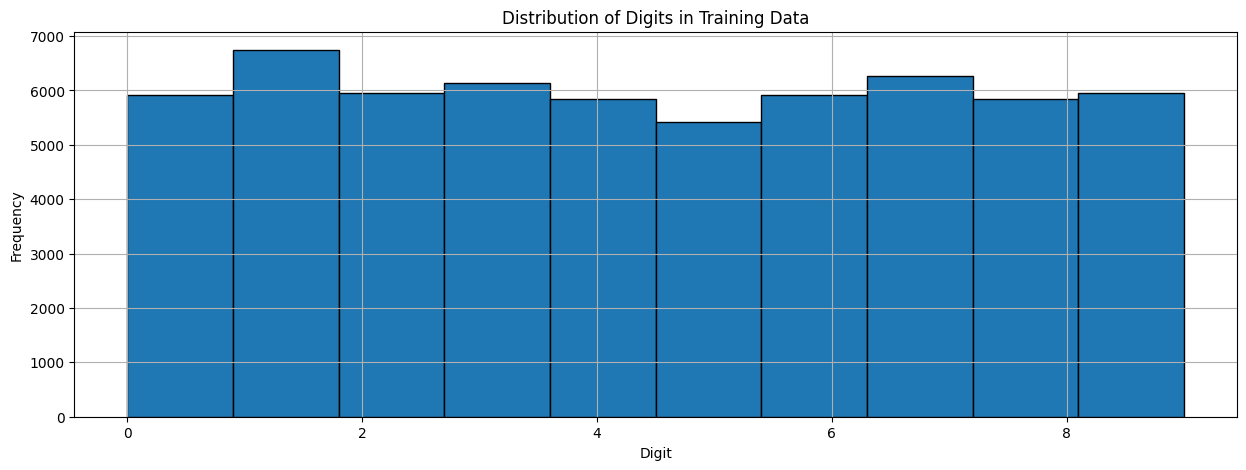

In [54]:
plt.figure(figsize=(15, 5))
plt.hist(y_train.get(), bins=10, edgecolor='black')
plt.title("Distribution of Digits in Training Data")
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

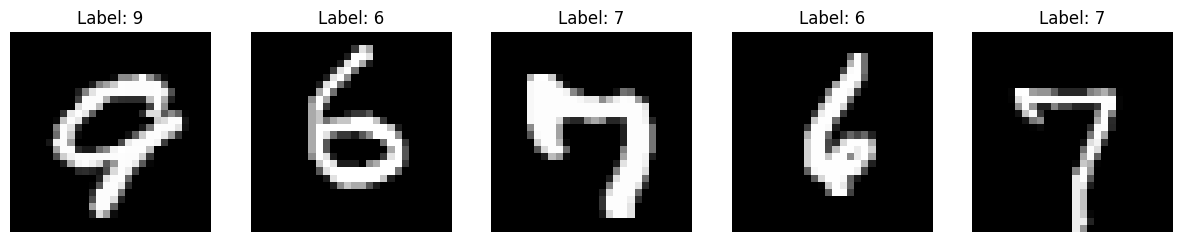

In [55]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    random_idx = cp.random.randint(0, len(X_train))
    image = X_train[random_idx].get().reshape(28, 28)  # Reshape the image
    label = y_train[random_idx].get()
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.show()

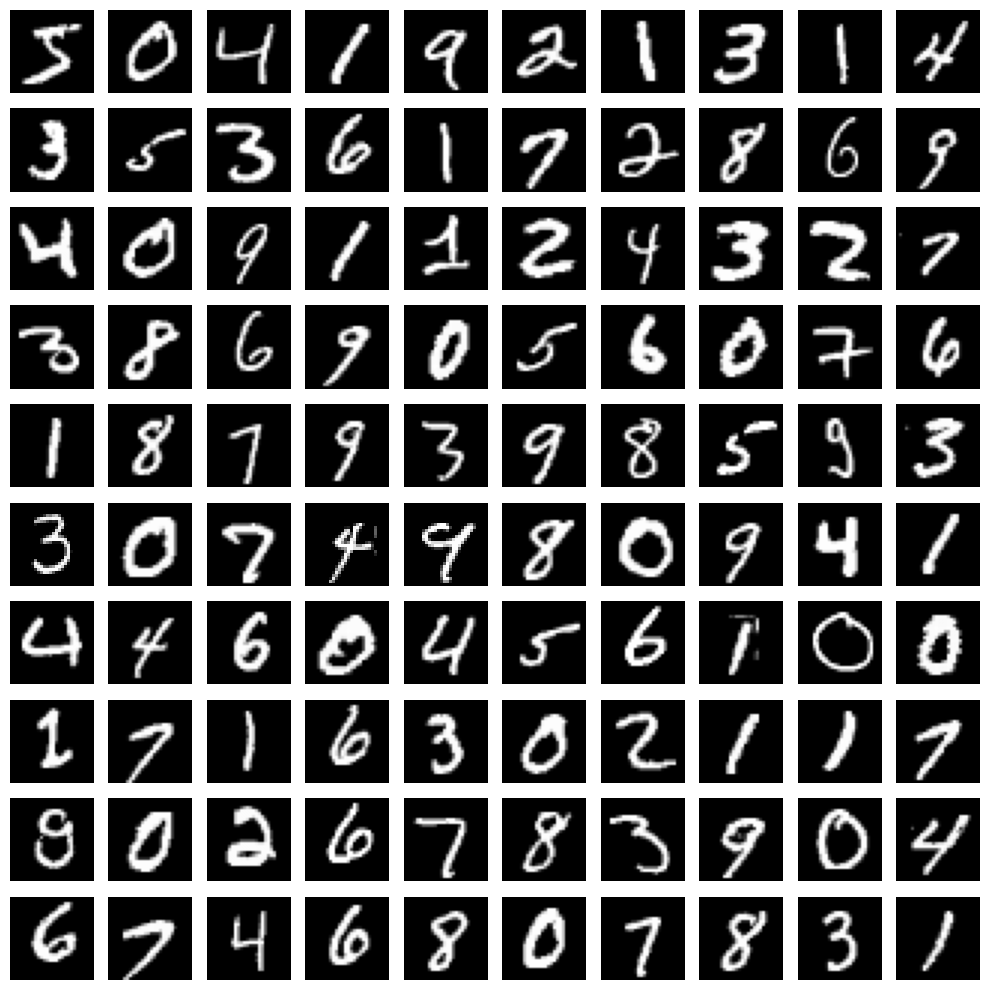

In [56]:
# Visualizing the first 100 images in a grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
axes = axes.flatten()

for i in range(100):
    image = X_train[i].get().reshape(28, 28)
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#Training the model

In [93]:
# Flatten the images (28x28) into a vector of length 784
X_train_flattened = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flattened = X_test.reshape(X_test.shape[0], -1) / 255.0

def one_hot_encode(y, num_classes=10):
    return cp.eye(num_classes)[y]

y_train_one_hot = one_hot_encode(y_train)
y_test_one_hot = one_hot_encode(y_test)

n_train_samples = 55000  # Use 55,000 for training
n_val_samples = 5000    # Use 5,000 for validation
indices = cp.arange(X_train_flattened.shape[0])
cp.random.shuffle(indices)
X_train_new = X_train_flattened[indices[:n_train_samples]]
y_train_new = y_train_one_hot[indices[:n_train_samples]]
X_val = X_train_flattened[indices[n_train_samples:n_train_samples + n_val_samples]]
y_val = y_train_one_hot[indices[n_train_samples:n_train_samples + n_val_samples]]

# Initialize MLP model
mlp = MLP(loss_function=CrossEntropyLoss, dropout_rate=0.15)
mlp.add_layer(input_size=784, num_neurons=512, activation_function=ReLU(), optimizer=Adam(learning_rate=1e-4))
mlp.add_layer(input_size=512, num_neurons=256, activation_function=ReLU(), optimizer=Adam(learning_rate=1e-4))
mlp.add_layer(input_size=256, num_neurons=128, activation_function=ReLU(), optimizer=Adam(learning_rate=1e-4))
mlp.add_layer(input_size=128, num_neurons=10, activation_function=Softmax(), optimizer=Adam(learning_rate=1e-4))

# Train the model with validation set
mlp.train(X_train_new, y_train_new, epochs=40, batch_size=128, verbose=True, X_val=X_val, y_val=y_val)

y_pred = mlp.forward(X_test_flattened)
predicted_labels = cp.argmax(y_pred, axis=1)

accuracy = Metric.accuracy(y_test_one_hot, y_pred)
precision = Metric.precision(y_test_one_hot, y_pred, average='macro')
recall = Metric.recall(y_test_one_hot, y_pred, average='macro')
f1_score = Metric.f1_score(y_test_one_hot, y_pred, average='macro')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1_score:.4f}")

Epoch 1/40 - Train Loss: 0.2711 | Val Loss: 0.2878
Epoch 2/40 - Train Loss: 0.1992 | Val Loss: 0.2195
Epoch 3/40 - Train Loss: 0.1650 | Val Loss: 0.1883
Epoch 4/40 - Train Loss: 0.1361 | Val Loss: 0.1591
Epoch 5/40 - Train Loss: 0.1181 | Val Loss: 0.1443
Epoch 6/40 - Train Loss: 0.1014 | Val Loss: 0.1262
Epoch 7/40 - Train Loss: 0.0876 | Val Loss: 0.1128
Epoch 8/40 - Train Loss: 0.0789 | Val Loss: 0.1051
Epoch 9/40 - Train Loss: 0.0709 | Val Loss: 0.0988
Epoch 10/40 - Train Loss: 0.0656 | Val Loss: 0.0978
Epoch 11/40 - Train Loss: 0.0588 | Val Loss: 0.0879
Epoch 12/40 - Train Loss: 0.0537 | Val Loss: 0.0869
Epoch 13/40 - Train Loss: 0.0491 | Val Loss: 0.0821
Epoch 14/40 - Train Loss: 0.0467 | Val Loss: 0.0820
Epoch 15/40 - Train Loss: 0.0430 | Val Loss: 0.0824
Epoch 16/40 - Train Loss: 0.0388 | Val Loss: 0.0785
Epoch 17/40 - Train Loss: 0.0357 | Val Loss: 0.0743
Epoch 18/40 - Train Loss: 0.0327 | Val Loss: 0.0723
Epoch 19/40 - Train Loss: 0.0300 | Val Loss: 0.0720
Epoch 20/40 - Train L

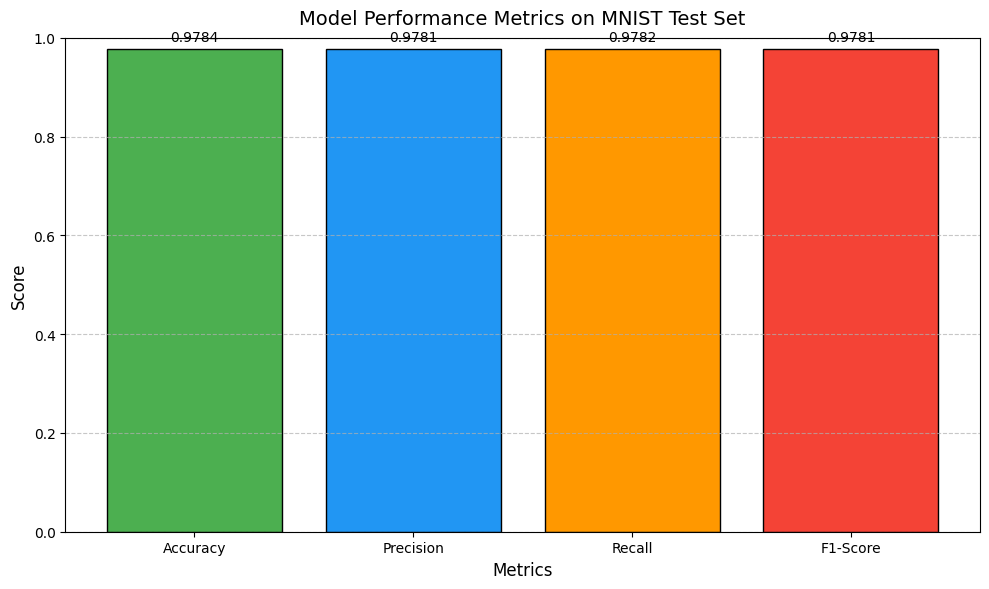

In [98]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy.get(), precision.get(), recall.get(), f1_score.get()]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#4CAF50', '#2196F3', '#FF9800', '#F44336'], edgecolor='black')

plt.title('Model Performance Metrics on MNIST Test Set', fontsize=14, pad=10)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Conclusion

The completion of this project represents a remarkable milestone: a simple Multi-Layer Perceptron (MLP) achieving an outstanding accuracy of 97.84% on the MNIST dataset, tantalizingly close to the 98% mark. This result highlights the strength and elegance of a well-crafted neural network, demonstrating that even without convolutional layers or advanced architectures, exceptional performance is attainable. Throughout this journey, we’ve explored the fundamental building blocks that power an MLP, each contributing significantly to this near-optimal outcome.

Our conversations delved into the essentials: the **loss function**, steering the model to minimize prediction errors; the **perceptron**, the core unit driving each layer; and the **layers** themselves, transforming inputs via weights, biases, and **activation functions** like ReLU and softmax. We examined the training mechanics of **epochs** and **batches**, leveraging mini-batch gradient descent for efficiency and stability. Techniques such as **dropout** and **L1/L2 regularization** proved crucial, enhancing generalization by curbing overfitting and managing weight magnitudes. Individually simple, these components combined to create a robust and effective model.

Reaching 97.84% accuracy on MNIST—a benchmark dataset of handwritten digits—shows that a straightforward MLP, when meticulously tuned with these building blocks, can approach the performance of more complex systems. This success reflects the insights gained from our discussions and the careful application of each element. It serves as a powerful reminder that mastering the fundamentals can deliver near-extraordinary results, setting the stage for future refinements—perhaps to cross that 98% threshold—or ventures into deeper networks and tougher datasets. For now, this project stands as a proud testament to the potential of core neural network principles.